In [1]:
import pandas as pd, numpy as np, geopandas as gpd
import matplotlib.pyplot as plt
from importlib import reload
import functools
%matplotlib inline

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

pd.set_option('precision', 3)
pd.options.display.float_format = '{:20.2f}'.format
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None

In [2]:
import urbanFormPy as up

In [3]:
#initialise path, names, etc.

city_name = 'London'
epsg = 27700
crs = {'init': 'epsg:27700', 'no_defs': True}

network_loading_path ='Outputs/'+city_name+'/intermediate/for Simulation/'+city_name
buildings_loading_path = 'Outputs/'+city_name+'/intermediate/for Simulation/'+city_name

In [4]:
# loading nodes, edges, landmarks
# At this point, every element has already been extracted

nodes = gpd.read_file(network_loading_path+'_nodes_simplified_BB.shp', driver='ESRI Shapefile')
edges = gpd.read_file(network_loading_path+'_edges_simplified_BB.shp', driver='ESRI Shapefile')
buildings = gpd.read_file(buildings_loading_path+'_landmarks.shp', driver='ESRI Shapefile')
sight_lines = gpd.read_file(buildings_loading_path+'_sight_lines_BB.shp', driver='ESRI Shapefile')

## Assigning buildings and scores to Nodes

In [7]:
# local landmarks
nodes = up.assign_local_landmarks_to_nodes(nodes, buildings, radius = 50)

In [8]:
# anchors
threshold = 0.30 # min global score to define a global landmark
max_radius = 1500 # max distance from node
nodes = up.assign_anchors_to_nodes(nodes, buildings, radius = max_radius, threshold = threshold)

In [9]:
# sight_lines = up.reassign_sight_lines_to_new_nodes(nodes, sight_lines)

In [10]:
sight_lines['nodeID'] = sight_lines['nodeID'].astype(int)
sight_lines['length'] = sight_lines.geometry.length
sight_lines = sight_lines[["buildingID", "length", "nodeID", "geometry"]].groupby(["buildingID", "nodeID"], 
                                                                       as_index = False).agg({"length" : max, "geometry": 'first'})
sight_lines = sight_lines[sight_lines.buildingID.isin(buildings[buildings.height >= 1].buildingID)]
sight_lines = gpd.GeoDataFrame(sight_lines[["buildingID", "length", "nodeID"]], crs=crs, geometry=sight_lines['geometry'])

In [11]:
nodes = up.assign_3d_visible_landmarks_to_nodes(nodes, buildings, sight_lines, threshold = threshold)

In [17]:
nodes['lScore'] = nodes.apply(lambda row: 0 if len(row['loc_scor']) == 0 else row['loc_scor'][0], axis = 1)
nodes['gScore'] = nodes.apply(lambda row: 0 if len(row['dist_scor']) == 0 else row['dist_scor'][0], axis = 1)

In [38]:
nodes['lScore'] = nodes.apply(lambda row: 0 if len(row['loc_scor']) == 0 else np.mean(row['loc_scor']), axis = 1)
nodes['gScore'] = nodes.apply(lambda row: 0 if len(row['dist_scor']) == 0 else np.mean(row['dist_scor']), axis = 1)

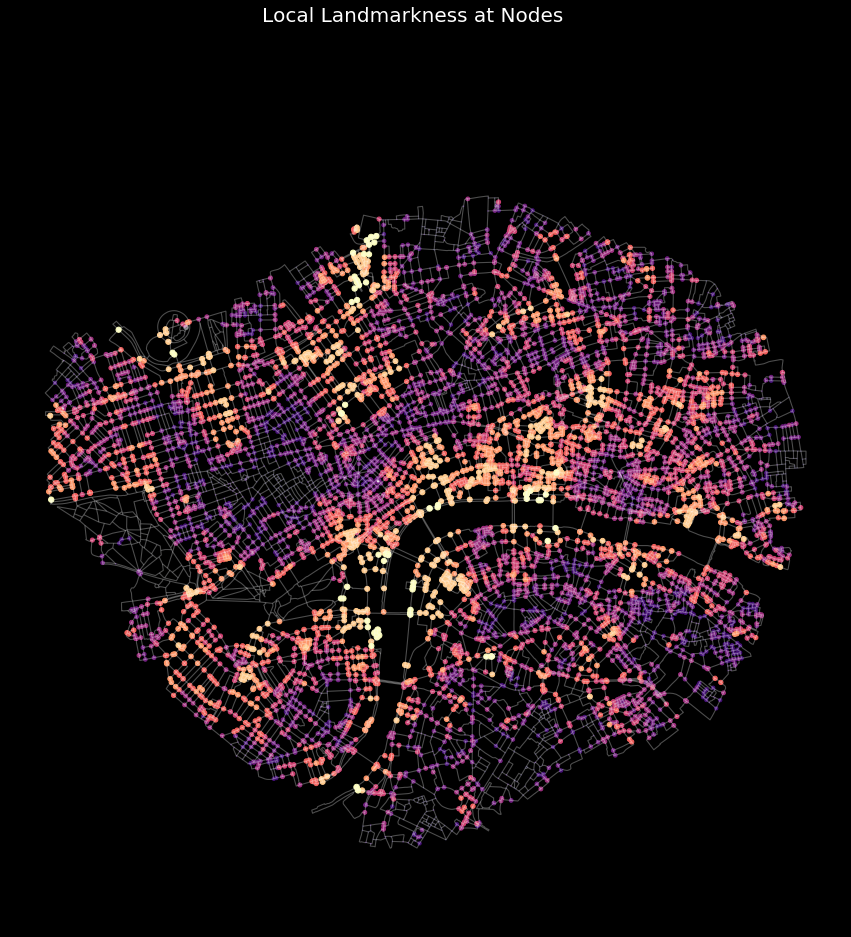

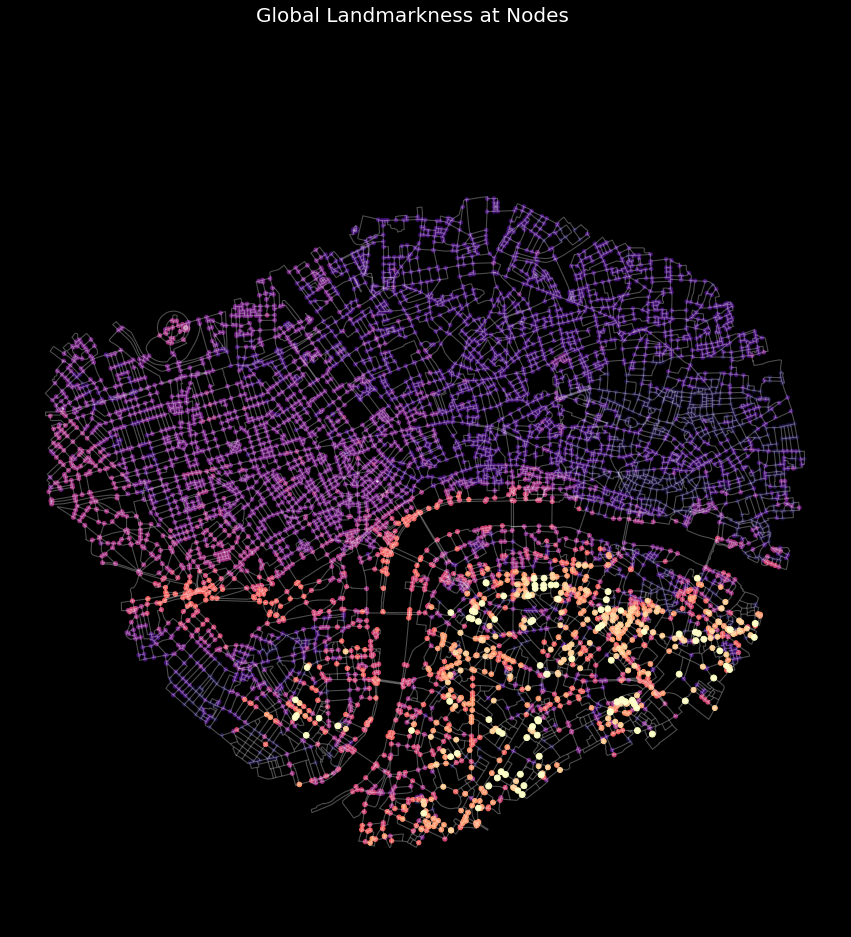

In [39]:
col = ['lScore', 'gScore']
title = ['Local Landmarkness at Nodes', 'Global Landmarkness at Nodes']

for n, i in enumerate(col):
    tmp = nodes.copy()
    # visualising by passing a series of markersize values (ms) 
    tmp['ms'] = np.where(tmp[i] >= threshold, tmp[i]*35, 0.15) # marker size
    up.plot_points(tmp, column = i, classes = 10, ms_col = 'ms', title = title[n], cmap = 'magma', fig_size = 15, 
                   gdf_base_map = edges)

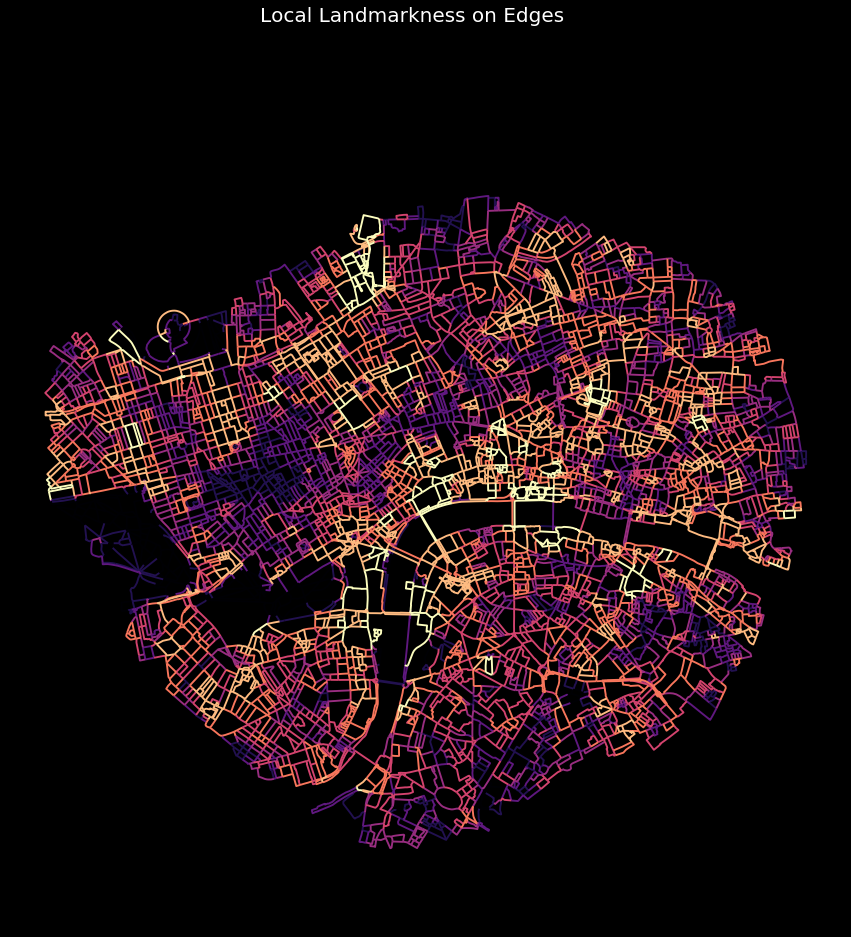

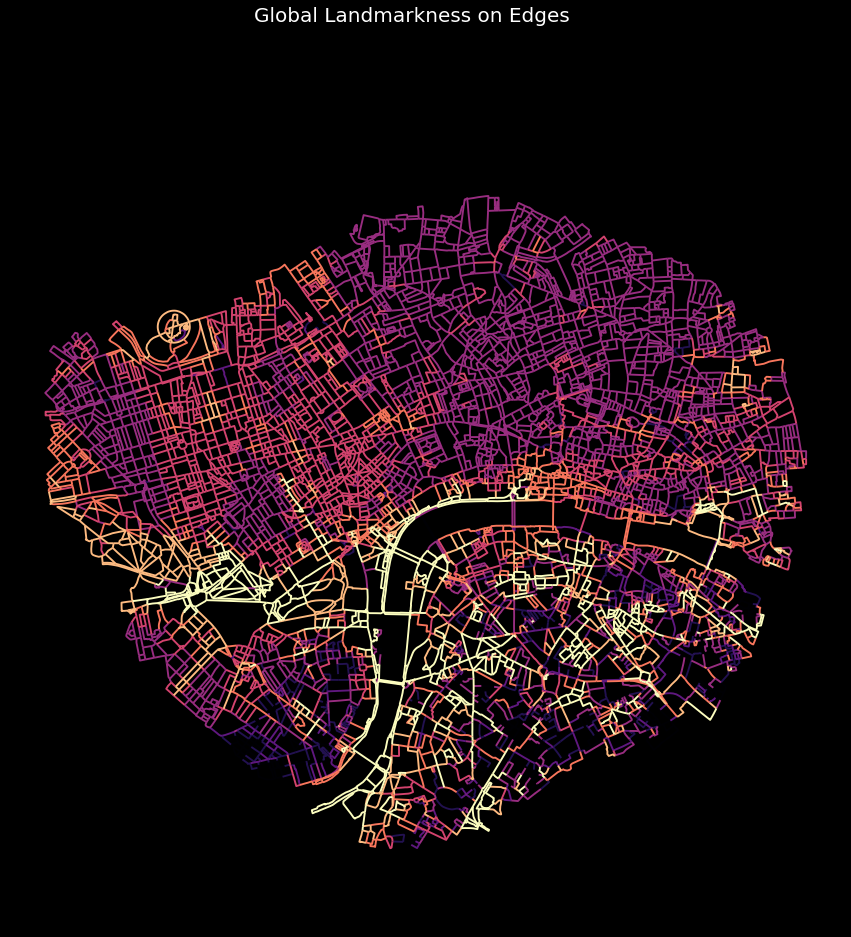

In [21]:
col = ['lScore', 'gScore']
title = ['Local Landmarkness on Edges', 'Global Landmarkness on Edges']
nodes.index= nodes.nodeID
del nodes.index.name

edges['lScore'] = edges.apply(lambda row: (nodes.loc[row['v']].lScore + nodes.loc[row['u']].lScore)/2, axis = 1)
edges['gScore'] = edges.apply(lambda row: (nodes.loc[row['v']].gScore + nodes.loc[row['u']].gScore)/2, axis = 1)

for n, i in enumerate(col):
    up.plot_lines(edges, classes = 8, column = i, title = title[n], lw = 1.9, 
                  scheme = 'Natural_Breaks', cmap = 'magma', fig_size =15)

## 2d advance Visibility Matrix

In [ ]:
v = up.compute_2d_visibility(nodes, buildings, distance_along = 50, max_distance_node_to_building = 300)

In [ ]:
matrix2d = up.build_2d_visibility_matrix(buildings, nodes, v)

In [ ]:
matrix2d.to_csv(path_output+'_visibility_matrix.csv')

## Conversion from lists to string, to export the file

In [35]:
saving_path = 'Outputs/'+city_name+'/intermediate/for Simulation/'+city_name
to_convert = ['loc_land', 'loc_scor', 'dist_land', 'dist_scor', 'anchors', 'distances']
nodes_string = nodes.copy()
for column in to_convert: nodes_string[column] = nodes_string[column].astype(str)
nodes_string.to_file(saving_path+'_nodes_simplified_BB.shp', driver='ESRI Shapefile')
# sight_lines.to_file(saving_path+'_sight_lines_BB.shp', driver='ESRI Shapefile')